In [29]:
import numpy as np
from matplotlib import pyplot as plt

In [59]:
class RuleBasedSystem(object):
    class Rule(object):
        def __init__(self, c, sigma_e_2, dim_ind, delta, salience):
            self.c = c #decision criterion
            self.sigma_e_2 = sigma_e_2 #?for Epsilon Poisson?
            self.dim_ind = dim_ind #i-index for dimension xi
            self.delta = delta #for updating salience (dE=-dC) or Ci? maybe rename?
            self.salience = salience #Zk
        
        #he(x)=xi-Ci
        def get_discriminant_value(self, x):
            return x[self.dim_ind] - self.c
        
        #Rule(i?): A if he(x)<eps, B if he(x)>eps
        def make_decision (self, x):
            h_e = self.get_discriminant_value(x) #he(xi)
            epsilon = np.random.normal(scale = np.sqrt(self.sigma_e_2))
            if h_e > epsilon:
                return "B"
            elif h_e <= epsilon: #why "=" too?, the rule sais "<"
                return "A"
            #зачем нам вводить епсилон если ниже мы все рaвно приравниваем к 0?
            
        def update_salience(self, delta):
            self.salience += delta 
            self.salience = max(0, self.salience) #to avoid negative salience values
            
            #rule update?
        def update(self, x, feedback):
            h_e = self.get_discriminant_value(x)
            if h_e > 0:
                deterministic_decision = 'B' #deterministic_decision=response
            elif h_e <= 0:
                deterministic_decision = 'A'
            
            # Larger c => greater chance of selecting 'A'
            if deterministic_decision == 'B' and feedback == 'A':
                self.c += self.delta # where we get this delta?
            elif deterministic_decision == 'A' and feedback == 'B':
                self.c -= self.delta
                
        def __str__(self):
            return 'One-dimensional rule on dimension {} with C={}'.format(
                self.dim_ind, self.c)
                
            
    def __init__(self, n_dims, sigma_e_2, gamma, lambdo, delta_c, delta_e, delta):
        
        self.n_dims = n_dims #number of dimensions (r) 
        self.sigma_e_2 =  sigma_e_2 #for epsilon ?
        self.gamma = gamma #perceverance, lower=easier_switch
        self.lambdo = lambdo #selection_param, =mu for Poisson for X, 
                            #higher lambdo=higher prob in n+1
        self.delta_c = delta_c #positive, perceived gain, =const(?)
        self.delta_e = delta_e #negative, perceived loss, =const(?)
        self.delta = delta  #? maybe rename
        
        c_init = 0.5 #B=0, A=1
        salience_init = 1.0 / n_dims
        
        self.rules = [self.Rule(c=c_init, 
                                sigma_e_2=sigma_e_2, 
                                dim_ind=dim_ind, 
                                delta=delta, 
                                salience=salience_init) 
                      for dim_ind in range(n_dims)]
        #Ri
        self.current_rule = np.random.choice(self.rules, 1)[0]
        
    def process_stimulus(self, x):
        self.current_rule = self._select_rule()
        self.last_stimulus = x
        self.current_prediction = self.current_rule.make_decision(x) #curent response
        
    def _select_rule(self):
        saliences = [rule.salience for rule in self.rules]
        
        # Perseveration, Yi(n)=Zi(n)+gamma
        current_rule_ind = self.rules.index(self.current_rule)
        saliences[current_rule_ind] += self.gamma
        
        # Select a random rule, Rj
        n_rules = len(self.rules)
        indices = list(range(n_rules))
        indices.remove(current_rule_ind) #remove Ri
        random_rule_ind = np.random.choice(indices, 1)[0] #select Rj
        
        # Add X to the random rule's salience, Yj(n)=Zj(n)+X
        X = np.random.poisson(lam=self.lambdo)
        saliences[random_rule_ind] += X
        
        # Select a rule randomly, p(Rk)=Yk(n)/sum(Ysal(n)) sum_sal: 1 to m
        pties = [salience / sum(saliences) for salience in saliences]
        return np.random.choice(self.rules, size=1, p=pties)[0]
        
    def process_feedback(self, feedback):
        is_correct = self.current_prediction == feedback
        self._update_saliences(feedback)
        self._update_rules(feedback)
        
        return is_correct
    
    def _update_saliences(self, feedback):
        if self.current_prediction == feedback:
            delta = self.delta_c
        else:
            delta = -self.delta_e
        self.current_rule.update_salience(delta=delta)
        
    def _update_rules(self, feedback):
        x = self.last_stimulus
        for rule in self.rules:
            rule.update(x, feedback)

In [69]:
rbs = RuleBasedSystem(n_dims=4, sigma_e_2=0.0, gamma=1.0, lambdo=5.0, delta_c=0.0025, 
                      delta_e=0.02, delta=0.05)

In [61]:
from itertools import product
stimuli = list(product((0, 1), repeat=4))

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

In [113]:
results = list()
for _ in range(500):
    stimulus_ind = np.random.randint(8)
    stimulus = stimuli[stimulus_ind]
    feedback = rb_categs[stimulus_ind]
    rbs.process_stimulus(stimulus)
    results.append(rbs.process_feedback(feedback))

In [114]:
stimulus

(0, 1, 0, 1)

In [115]:
feedback

'A'

In [65]:
[rule.c for rule in rbs.rules]

[0.5, 0.5, 0.5, 0.5]

In [119]:
[rule.salience for rule in rbs.rules]

[0.5599999999999989,
 0.42250000000000026,
 0.5125000000000001,
 0.5524999999999991]

In [116]:
results

[False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 Tru

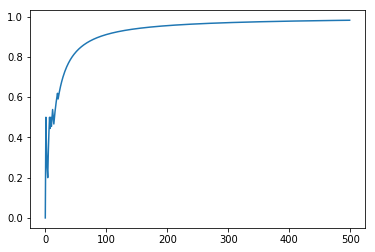

In [118]:
plt.plot(np.cumsum(results) / (np.arange(len(results)) + 1))

In [28]:
np.random.randint(8)

7

In [52]:
%pdb

Automatic pdb calling has been turned OFF


In [110]:
rbs.process_stimulus(stimulus)

In [111]:
rbs.current_prediction

'A'

In [112]:
rbs.current_prediction == feedback

True

In [109]:
rbs.current_rule.make_decision(stimulus)

'A'